# PRIM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
from ema_workbench import RealParameter, CategoricalParameter, ScalarOutcome, ema_logging, load_results
from ema_workbench.analysis import lines, prim
from ema_workbench.analysis.plotting_util import Density

In [2]:
wd = r'./results'

### Load results

In [3]:
results = load_results(wd+"/results_final.tar.gz")
experiments, outcomes = results[0].copy(), results[1].copy()

### Set conditions
Setting thresholds for expected and unexpected output spaces:
- Expected: bike distance exceeds car distance at final time
- Unexpected: car distance does not exceed car distance at final time

In [4]:
def expected(outcomes):
    
    bike_final = np.array([bike_ts[-1] for bike_ts in outcomes["Bike Distance Share"]])
    car_final = np.array([car_ts[-1] for car_ts in outcomes["Car Distance Share"]])

    
    y = (bike_final > 1.5*car_final)
    
    return y

def unexpected(outcomes):

    bike_final = np.array([bike_ts[-1] for bike_ts in outcomes["Bike Distance Share"]])
    car_final = np.array([car_ts[-1] for car_ts in outcomes["Car Distance Share"]])

    y = (bike_final < 1.5*car_final) 
    
    return y   

In [13]:
for ref_mode in ["Fraction of City Population with Bike Access"]:
    initial = np.array([ts[0] for ts in outcomes[ref_mode]])
    final = np.array([ts[-1] for ts in outcomes[ref_mode]])
    diff = abs(np.subtract(final, initial))
    max_diff = diff.max() / initial[0]
    min_diff = diff.min() / initial[0]
    print(f'{ref_mode}:\n{min_diff:.0%} - {max_diff:.0%}')


for ref_mode in ["Variation in Subjective Travel Time by Bike", "Variation in Subjective Travel Time by PT", "Variation in Subjective Travel Time by Car"]:
    final = np.array([ts[-1] for ts in outcomes[ref_mode]])
    max_final = abs(final).max() 
    min_final = abs(final).min()
    print(f'{ref_mode}:\n{min_final:.0%} - {max_final:.0%}')

Fraction of City Population with Bike Access:
28% - 235%
Variation in Subjective Travel Time by Bike:
21% - 60%
Variation in Subjective Travel Time by PT:
6% - 31%
Variation in Subjective Travel Time by Car:
0% - 32%


### Plot lines
Grouped by expected and unexpected

condition_met
Unexpected    0.658
Expected      0.342
Name: count, dtype: float64


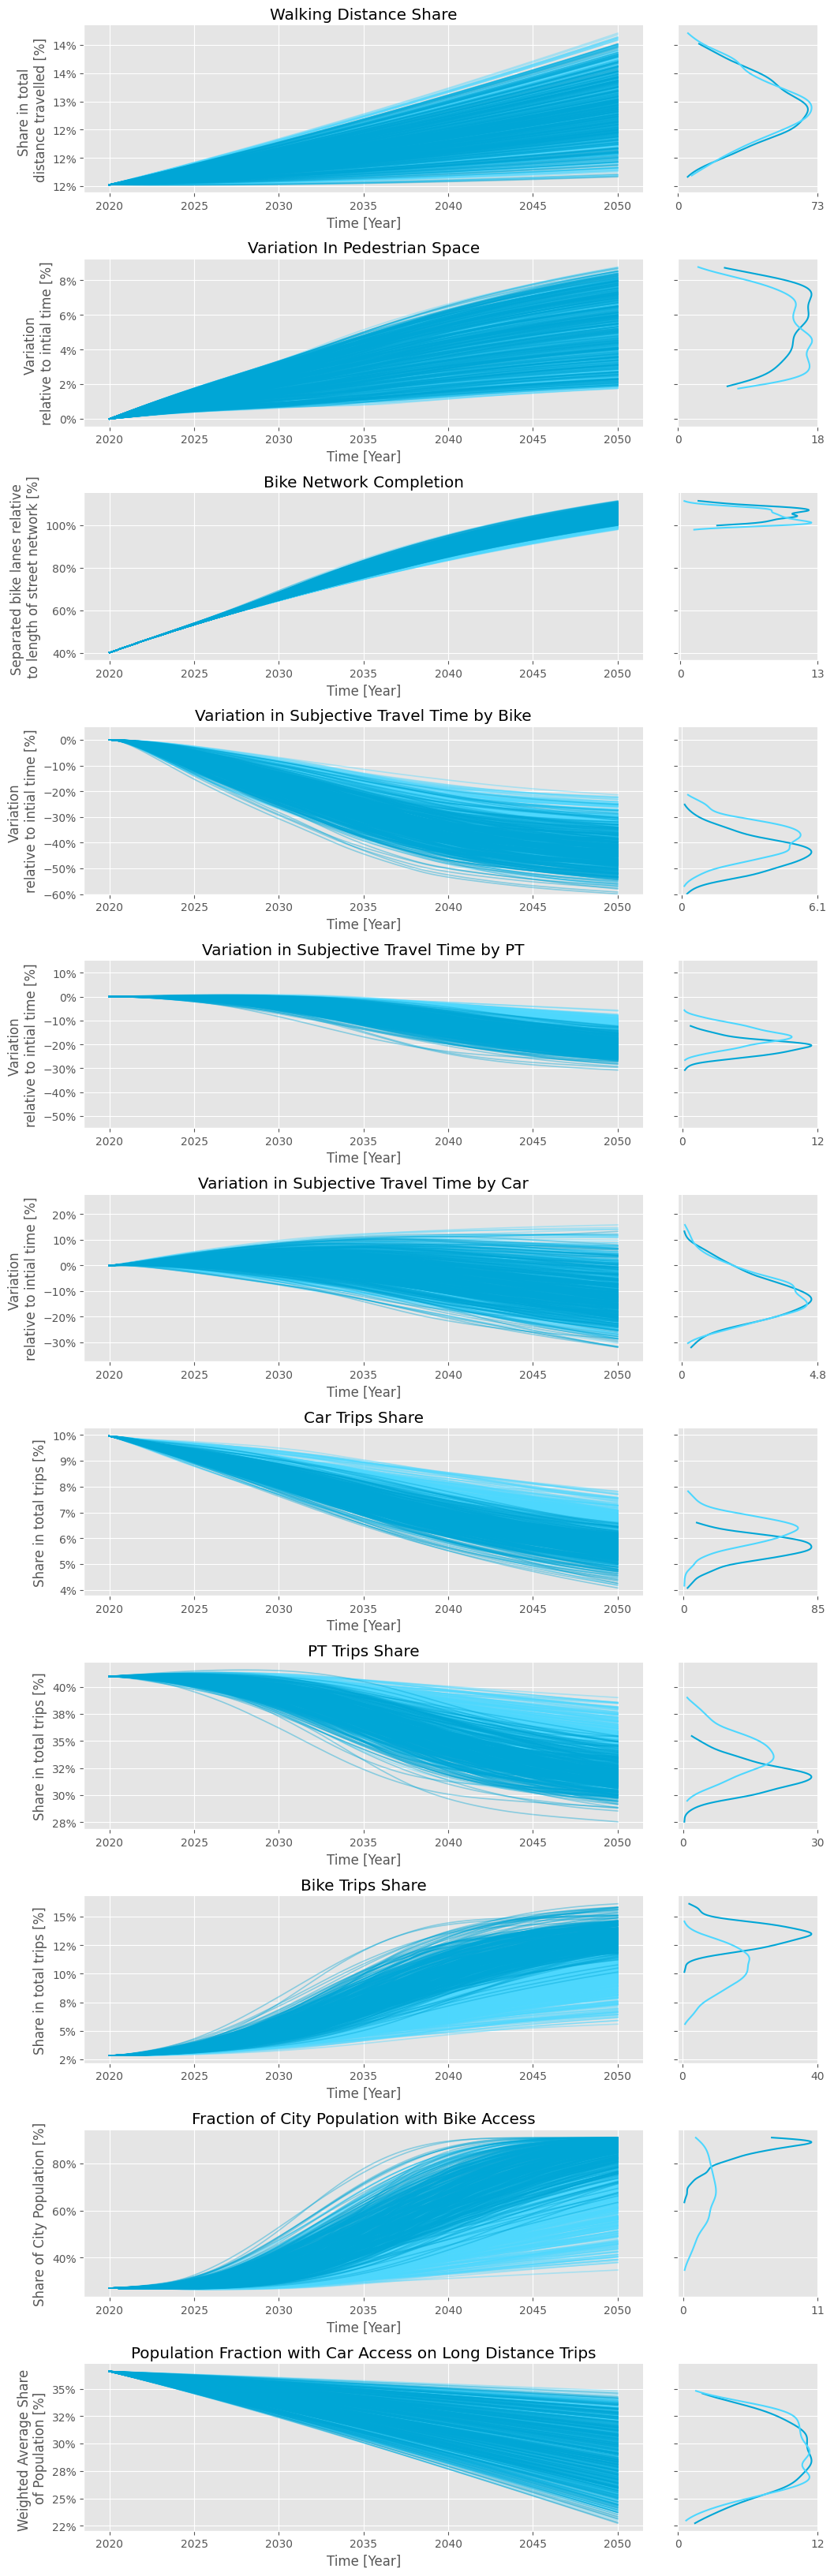

In [9]:
# Basic settings
OUTCOMES = ['Walking Distance Share', 'Variation In Pedestrian Space', 'Bike Network Completion', 'Variation in Subjective Travel Time by Bike', 
            'Variation in Subjective Travel Time by PT', 'Variation in Subjective Travel Time by Car', 'Car Trips Share', 'PT Trips Share', 'Bike Trips Share',
           'Fraction of City Population with Bike Access', 'Population Fraction with Car Access on Long Distance Trips' ]
ylabels = {key: "Share in total \ndistance travelled [%]" for key in OUTCOMES}
ylabels.update({key: "Variation \nrelative to intial time [%]" for key in ['Variation In Pedestrian Space', 'Variation in Subjective Travel Time by PT', 
                                                                       'Variation in Subjective Travel Time by Bike', 'Variation in Subjective Travel Time by Car']})
ylabels.update({key: "Share in total trips [%]" for key in ['Car Trips Share', 'PT Trips Share', 'Bike Trips Share']})
ylabels.update({'Bike Network Completion': "Separated bike lanes relative \nto length of street network [%]"})
ylabels.update({'Fraction of City Population with Bike Access': "Share of City Population [%]"})
ylabels.update({'Population Fraction with Car Access on Long Distance Trips': 'Weighted Average Share \nof Population [%]'})

plt.rcParams['figure.figsize'] = (12, 3.75 * len(OUTCOMES))
plt.style.use('ggplot')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.rm'] = 'Arial'
colors = ['#4DD7FF', '#00A6D6'] # Condition not met, condition met
HALF = True # only show right half of timeseries

# Mark these outcomes
condition_unmet = unexpected(outcomes)
condition_met = expected(outcomes)
experiments['condition_met'] = np.where(unexpected(outcomes), 'Unexpected', 'Expected')
print(experiments['condition_met'].value_counts() / len(experiments))

# Use standard plotting method grouped by condition
fig, axes = lines(
    experiments,
    outcomes,
    OUTCOMES,
    group_by='condition_met',
    density=Density.KDE,
    ylabels=ylabels,
    legend=False
)

# Set custom y-scales to make sure y-intervals in the graphs are equal, even when limits are different
axes['Variation in Subjective Travel Time by Bike'].set_ylim(-0.6, 0.05)
axes['Variation in Subjective Travel Time by Car'].set_ylim(-0.375, 0.275)
axes['Variation in Subjective Travel Time by PT'].set_ylim(-0.55, 0.15)

for label in OUTCOMES:
    axes[label].yaxis.set_major_formatter(PercentFormatter(1,0))

# Now remove the differently colored lines but keep the rest of the axes
lineplot = True
for outcome, ax in axes.items():
    if lineplot:
        for line in ax.lines:
            line.set_visible(False)  # Set transparency for the condition not met lines
        ax.xaxis.set_label_text('Time [Year]')    
        lineplot = False
    else:
        ax.lines[0].set_color(colors[1])
        ax.lines[1].set_color(colors[0])
        lineplot = True

# Now redraw the lines, but this time colored based on the condition
for outcome in OUTCOMES:
    ax = axes[outcome]  # Get the correct axis for each outcome

    # Plot lines that meet the condition in blue, with higher z-order to overlay them
    for i, line_data in enumerate(outcomes[outcome]):
        if condition_unmet[i]:  # If condition met, plot in pink on top
            ax.plot(outcomes['TIME'][i], line_data, color=colors[0], linewidth=1.2, zorder=2, alpha=0.4)

    # Plot lines that meet the condition in blue, with higher z-order to overlay them
    for i, line_data in enumerate(outcomes[outcome]):
        if condition_met[i]:  # If condition met, plot in blue on top
            ax.plot(outcomes['TIME'][i], line_data, color=colors[1], linewidth=1.2, zorder=3, alpha=0.4)

# Loop over each axis to despine
for outcome, ax in axes.items():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.show()
plt.rcdefaults()

In [8]:
fname = "stylized_other_outcomes"
fig.savefig(f"./results/{fname}.png", bbox_inches='tight',dpi=250)

In [45]:
for ref_mode in ['Variation in Subjective Travel Time by PT', 'Variation in Subjective Travel Time by Bike', 
                 'Variation in Subjective Travel Time by Car', 'Fraction of City Population with Bike Access',
                'Population Fraction with Car Access on Long Distance Trips']:
    final = np.array([ts[-1] for ts in outcomes[ref_mode]])
    final_abs = abs(final)
    max_diff = final_abs.max()
    min_diff = final_abs.min()
    print(f'{ref_mode}:\n{min_diff:.0%} - {max_diff:.0%}')

Variation in Subjective Travel Time by PT:
0% - 25%
Variation in Subjective Travel Time by Bike:
20% - 58%
Variation in Subjective Travel Time by Car:
0% - 32%
Fraction of City Population with Bike Access:
26% - 95%
Population Fraction with Car Access on Long Distance Trips:
24% - 35%


### One by one

In [62]:
print(OUTCOMES
     )

['Walking Distance Share', 'Variation In Pedestrian Space', 'Bike Network Completion', 'Variation in Subjective Travel Time by Bike', 'Variation in Subjective Travel Time by PT', 'Variation in Subjective Travel Time by Car', 'Car Trips Share', 'PT Trips Share', 'Bike Trips Share', 'Fraction of City Population with Bike Access', 'Population Fraction with Car Access on Long Distance Trips']


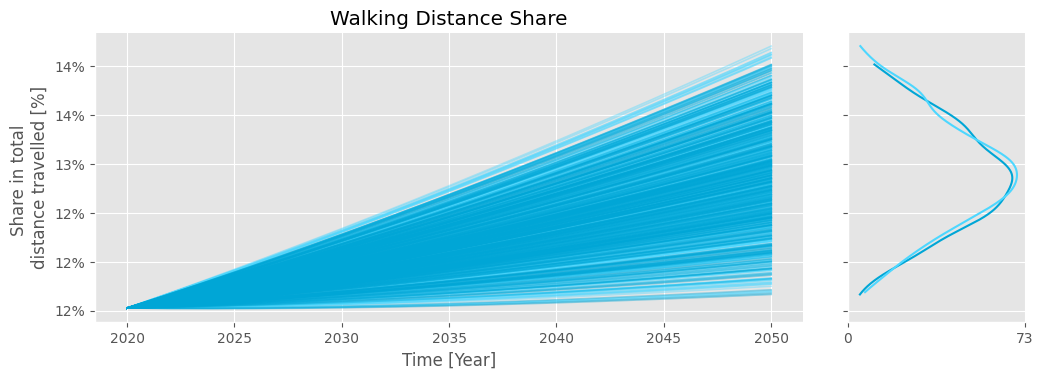

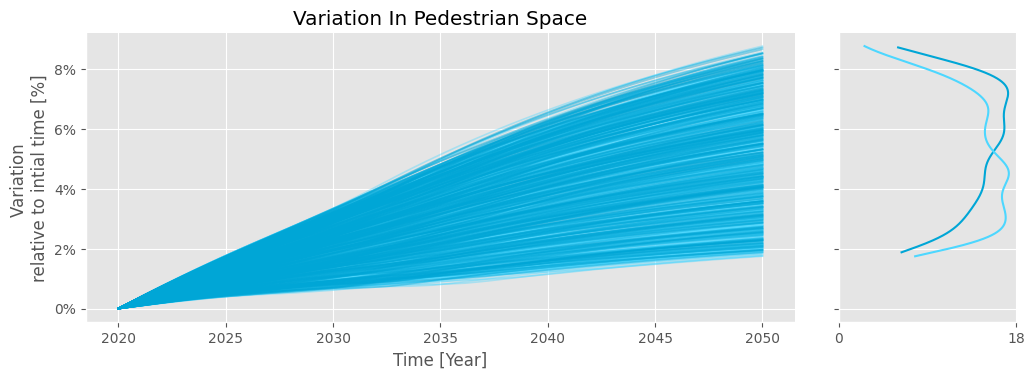

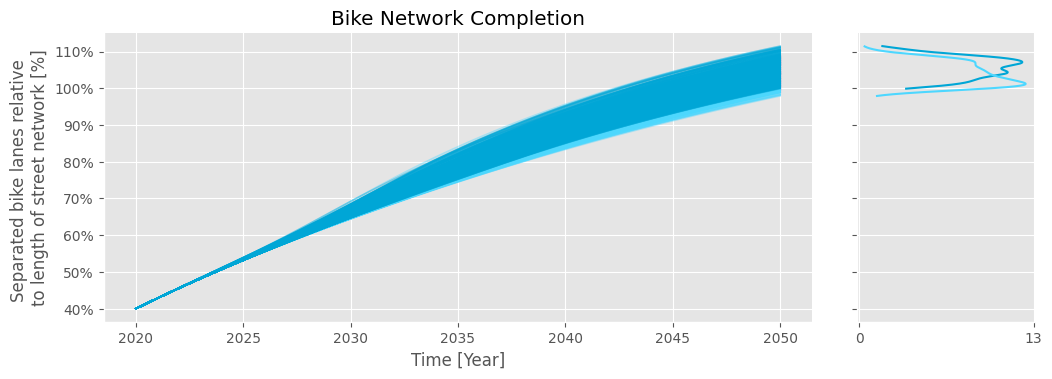

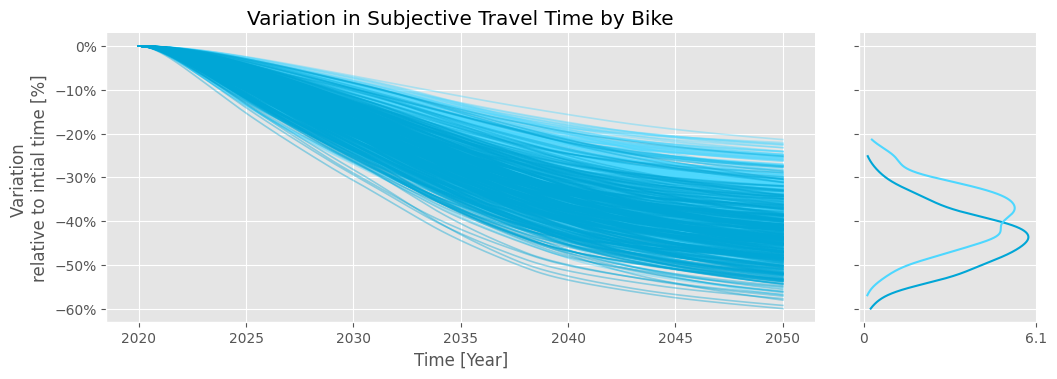

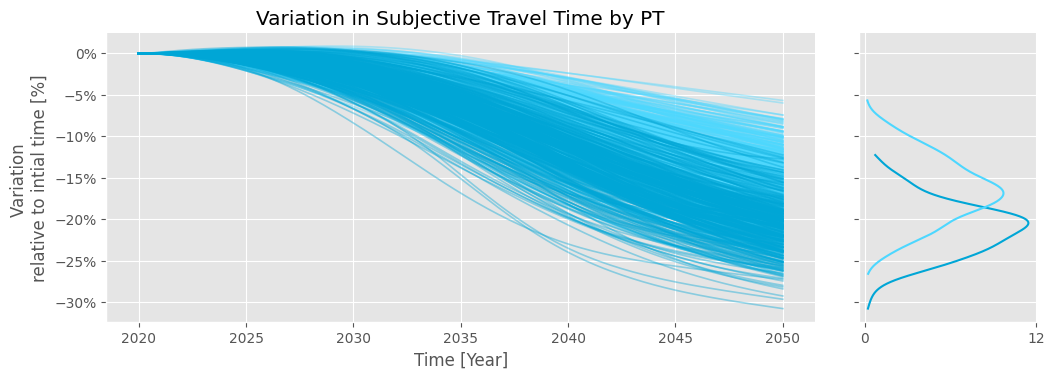

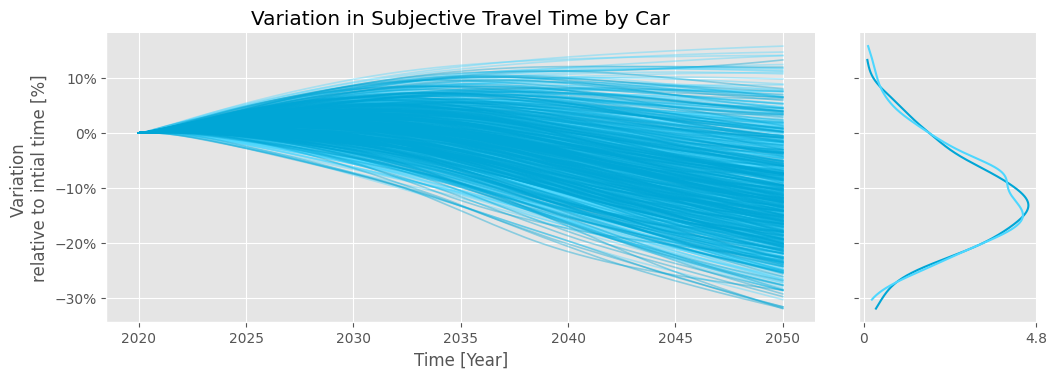

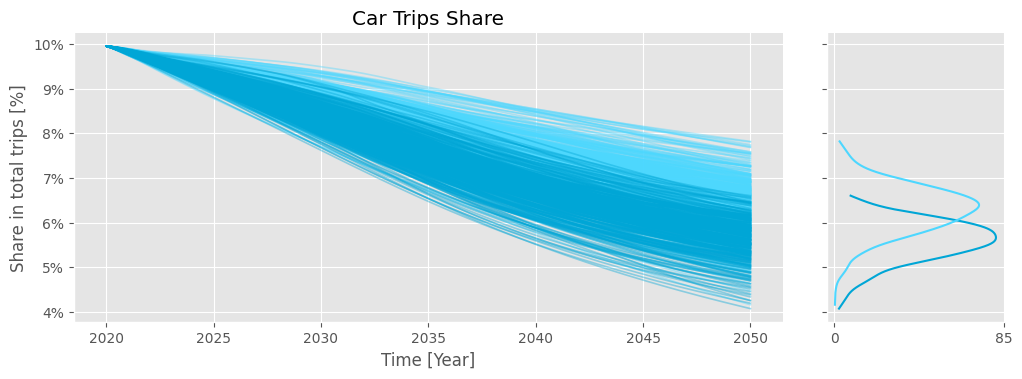

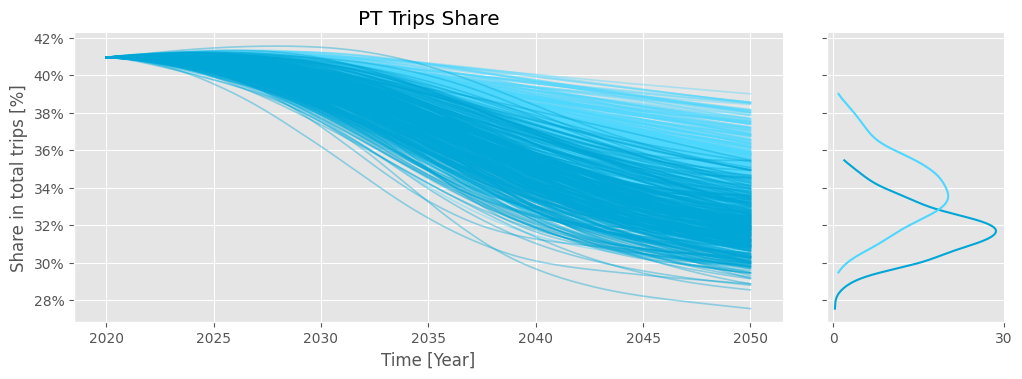

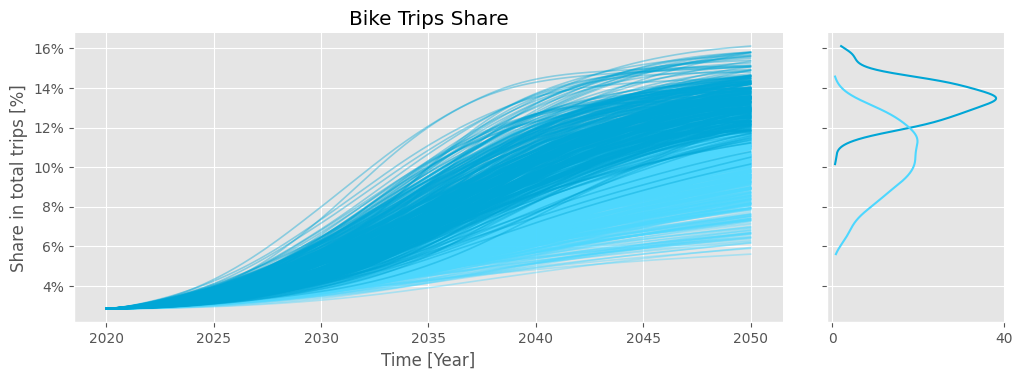

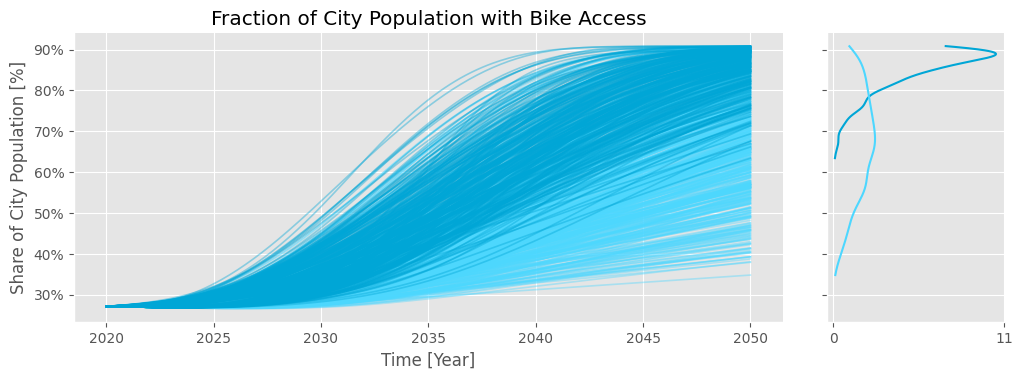

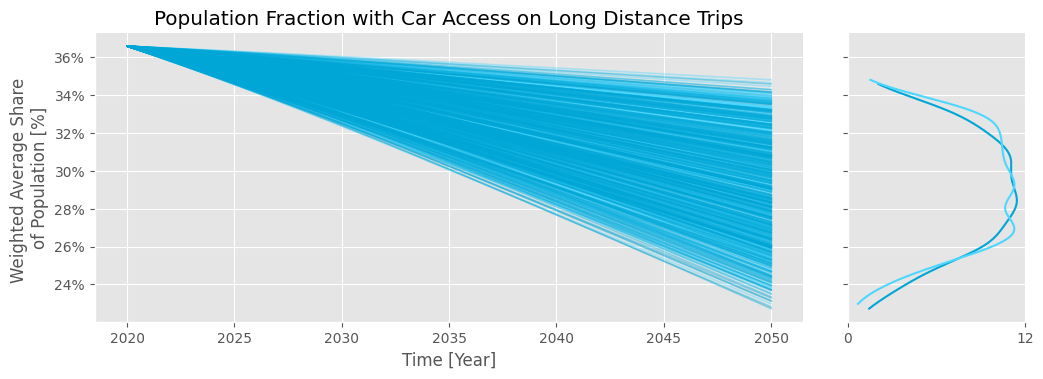

In [11]:
plt.rcParams['figure.figsize'] = (12, 3.75)
plt.style.use('ggplot')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.rm'] = 'Arial'
colors = ['#4DD7FF', '#00A6D6'] # Condition not met, condition met

# Mark these outcomes
condition_unmet = unexpected(outcomes)
condition_met = expected(outcomes)
experiments['condition_met'] = np.where(unexpected(outcomes), 'Unexpected', 'Expected')

for outcome in OUTCOMES:
    # Use standard plotting method grouped by condition
    fig, axes = lines(
        experiments,
        outcomes,
        outcome,
        group_by='condition_met',
        density=Density.KDE,
        ylabels=ylabels,
        legend=False
    )

    ax = axes[outcome]
    ax.yaxis.set_major_formatter(PercentFormatter(1,0))

    ax.xaxis.set_label_text('Time [Year]')  

    for line in ax.lines:
        line.set_visible(False)  # Set transparency for the condition not met lines
    axes[outcome+'_density'].lines[0].set_color(colors[1])
    axes[outcome+'_density'].lines[1].set_color(colors[0])

    # Now redraw the lines, but this time colored based on the condition

    # Plot lines that meet the condition in blue, with higher z-order to overlay them
    for i, line_data in enumerate(outcomes[outcome]):
        if condition_unmet[i]:  # If condition met, plot in pink on top
            ax.plot(outcomes['TIME'][i], line_data, color=colors[0], linewidth=1.2, zorder=2, alpha=0.4)

    # Plot lines that meet the condition in blue, with higher z-order to overlay them
    for i, line_data in enumerate(outcomes[outcome]):
        if condition_met[i]:  # If condition met, plot in blue on top
            ax.plot(outcomes['TIME'][i], line_data, color=colors[1], linewidth=1.2, zorder=3, alpha=0.4)
    
    # Loop over each axis to despine
    for _, ax in axes.items():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    fname = f"stylized_{outcome}".replace(" ", "_")
    fig.savefig(f"./results/{fname}.png", bbox_inches='tight',dpi=250)
    
plt.rcdefaults()